##  Condition Co-occurrence Heatmap — Overview

In this section, we explore **which clinical conditions tend to occur together within the same visit**.

Rather than analyzing conditions in isolation, we focus on their **pairwise co-occurrence**. In other words:

> If *Condition A* appears in a visit, how often does *Condition B* appear in the **same** visit?

This type of analysis is useful because it can:

- Reveal **common comorbidities** (conditions that frequently appear together)
- Highlight **syndromic patterns** or typical diagnostic groupings
- Inform **clinical decision support** and **care pathway design**
- Provide a foundation for more advanced methods, such as **clustering** or **graph/network analysis**

The final output is a **heatmap** where:

- Each axis lists the **top frequent conditions**
- Each cell shows how often a **pair of conditions** appears together
- Darker colors indicate **stronger co-occurrence** between conditions


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
#  Setup 
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

# Initialize random number generator for reproducibility, Panda's utilizes NumPy module not "random"
np.random.seed(42)

In [3]:
# Load data
df = pd.read_csv("final_with_deceased.csv")

##  Step 1: Clean and Reshape Condition Data

The raw `condition` field can hold **multiple conditions in one string**, separated by `:`.  
To analyze co-occurrence, we first normalize this into one condition per row.

We:

1. Use `split_conditions()` to:
   - Split on `:` (flexible spacing)  
   - Strip extra spaces  
   - Drop empty tokens  

2. Store results in `df["condition_list"]`.

3. Use `explode()` to create one row per `(visit_occurrence_id, condition_item)`.

4. Drop rows without a valid `condition_item`.

5. Remove duplicates within the same visit to avoid double-counting:

```text
visit_occurrence_id | person_id | visit_start_date | condition_item


In [4]:
import re

# robust split on ":" allowing extra spaces; keep NaN if empty
def split_conditions(s):
    if pd.isna(s) or str(s).strip() == "":
        return []
    # split on ":" with optional surrounding spaces
    parts = re.split(r"\s*:\s*", str(s))
    # normalize: strip, drop empties, lower (or title-case if you prefer)
    parts = [p.strip() for p in parts if p and p.strip()]
    return parts

# apply once to create a list-typed column
df["condition_list"] = df["condition"].map(split_conditions)

In [5]:
cond_long = (
    df[["visit_occurrence_id", "person_id", "visit_start_date"]]
      .assign(condition_item=df["condition_list"])
      .explode("condition_item", ignore_index=True)
)

# drop rows where no condition exists after cleaning
cond_long = cond_long.dropna(subset=["condition_item"])

# (optional) dedupe within visit in case the same condition appears twice
cond_long = cond_long.drop_duplicates(subset=["visit_occurrence_id", "condition_item"])

## Step 2: Build the Co-occurrence Matrix

Next, we quantify **how often conditions appear together** in the same visit.

We:

1. Select the **Top N most frequent conditions** (here, `N = 10`) to keep the plot readable.  
2. Build a **visit × condition** binary matrix:
   - Rows = visits  
   - Columns = conditions  
   - Cell = 1 if the visit includes that condition, else 0  

3. Compute the **co-occurrence matrix**
Each cell (i, j) = number of visits where both conditions i and j are present.

4. Set the diagonal to 0 (we’re interested in pairs, not self-counts).

5. Create an upper-triangular mask so we only display one half of the symmetric matrix.


In [6]:
# what conditions co-occur?
# Co-occurrence (conditions that tend to appear together per visit)

N = 10
topN = cond_long["condition_item"].value_counts().head(N).index

matrix = (
    cond_long[cond_long["condition_item"].isin(topN)]
    .assign(val=1)
    .pivot_table(index="visit_occurrence_id", columns="condition_item", values="val", fill_value=0)
)

# co-occurrence counts (symmetric)
cooc_cnt = matrix.T.dot(matrix)   # diagonal = occurrences of each condition

np.fill_diagonal(cooc_cnt.values, 0)  # hide self-counts on diagonal

mask = np.triu(np.ones_like(cooc_cnt, dtype=bool), k=1)






##  Step 3: Heatmap Visualization & Interpretation

We visualize the co-occurrence matrix using a **Seaborn heatmap**:

- Axes: Top conditions (same labels on X and Y)  
- Color: Co-occurrence count (`cbar` shows the scale)  
- Masking: Only the lower triangle is shown for clarity  

**How to read the heatmap:**

- Darker cells → condition pairs that **frequently co-occur** in the same visit  
- Lighter cells → pairs that rarely appear together  
- Blocks of darker cells → **clusters of related conditions**, suggesting comorbidities or shared clinical pathways

This plot provides an at-a-glance view of **which conditions “travel together”** in the dataset.


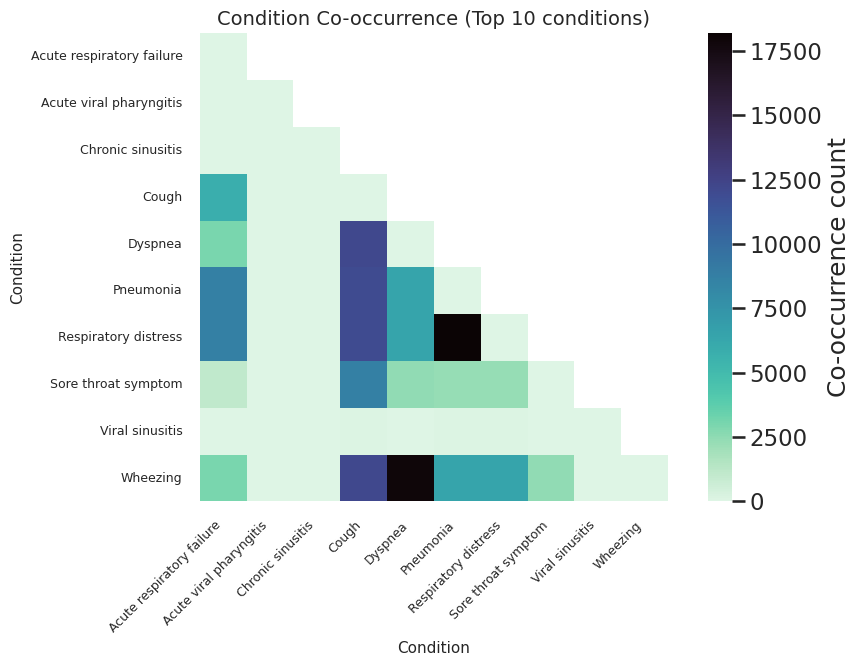

In [8]:
plt.figure(figsize=(10, 7))  # reduced from (15, 10)

ax = sns.heatmap(
    cooc_cnt,
    mask=mask,                 # keep asymmetric if needed
    cmap="mako_r",
    square=True,
    linewidths=0,
    cbar_kws={"label": "Co-occurrence count"}
)

ax.set_title(
    f"Condition Co-occurrence (Top {len(cooc_cnt)} conditions)",
    fontsize=14
)
ax.set_xlabel("Condition", fontsize=11)
ax.set_ylabel("Condition", fontsize=11)

ax.grid(False)

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.show()
